# Fitting a time-averaged spectrum

This notebook shows how to fit a time-averaged X-ray spectrum in nDspec. For least-chi squares fitting, nDspec makes use of the [lmfit library](https://lmfit.github.io/lmfit-py/). For error estimation, we encourage users to use Bayesian sampling, as detailed in the [tutorial on fitting power spectra](https://ndspec.readthedocs.io/en/latest/fit_psd.html). 

The current implementation of nDspec is targeted towards analyzing high count rate observations, in which spectral/timing studies are possible. As a result, the software does not yet have any functionality to perform background subtraction, or to account for the changes in fit statistic caused by the background [equivalent to that of Xspec](https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/XSappendixStatistics.html). Users should make sure that the `.pha` files they model are either background-subtracted, or that their chosen observation has a high enough count rate to make the background contribution negligible (e.g., a bright X-ray binary observed with NICER). Additionally, nDspec currently only makes used for the chi-squared statistic.

In [1]:
import os
import sys
import numpy as np

sys.path.append('/home/matteo/Software/nDspec/src/')
from ndspec.Response import ResponseMatrix
import ndspec.FitTimeAvgSpectrum as fitspec
import ndspec.models as models

## Loading and plotting data

Loading a time-averaged spectrum always requires users to first load a `ResponseMatrix` object. Once the response is loaded, we can declare a `FitTimeAvgSpectrum` object, and then pass both the `ResponseMatrix` file and the `.pha` file we are interested in to the `set_data` method. The spectrum file itself is processed through a built-in nDspec function, `load_pha`, which makes use of Astropy to load the appopriate arrays. The data is always stored in units of total counts, divided by exposure and channel width (ie, counts/s/keV) as a function of energy channel width.

In [2]:
path = os.getcwd() + "/data/"

rmfpath = path+"1200120106_rmf.pha"
nicer_matrix = ResponseMatrix(rmfpath)
arfpath = path+"1200120106_arf.pha"
nicer_matrix.load_arf(arfpath)

spectrum_fit = fitspec.FitTimeAvgSpectrum()

spectrum_fit.set_data(nicer_matrix,path+'1200120106_rebin.pha')

Arf missing, please load it
Arf loaded


We can now plot the data. nDspec allows users to plot data in both folded and unfolded units. Unfolding is performed in a model independent way, following the method implemented in ISIS and discussed in [Gunderson and Huenemoerder 2024](https://arxiv.org/pdf/2410.21449). This is different (and more robust) than the method used in Xspec, because it does not require users to specify a model for unfolding the data, and does not cause spurious features to appear in the spectrum depending on the model chosen for it. The units on the y axis are set following the same convention as Xspec: adding an `e` in the labels argument multiplies the y axis by a single unit of energy. 

Before running a fit, it is good practice to ignore energy ranges appropriate for a given mission - for typical soft X-ray missions, this might mean restricting the noticed energies between 0.5 and 10 keV. nDspec allows users to selectively notice/ignore any energy range (in units of keV) they choose in their analysis, e.g. by excluding regions where a line might appear.

Note that unfolding may raise warnings if a given channel in a spectrum has 0 counts for any photon energy. This is to be expected and should generally not be cause for concern, particularly if users are restricting the noticed energies to a sensible range. The warnings are left in this notebook for the sake of clarity.

/home/matteo/Software/nDspec/src/ndspec/Response.py:644: RuntimeWarning: divide by zero encountered in divide
  unfold_model = array/unfold_array*channel_widths
/home/matteo/Software/nDspec/src/ndspec/Response.py:644: RuntimeWarning: invalid value encountered in divide
  unfold_model = array/unfold_array*channel_widths
/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:3465: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err
/home/matteo/Software/nDspec/src/ndspec/Response.py:644: RuntimeWarning: divide by zero encountered in divide
  unfold_model = array/unfold_array*channel_widths
/home/matteo/Software/nDspec/src/ndspec/Response.py:644: RuntimeWarning: invalid value encountered in divide
  unfold_model = array/unfold_array*channel_widths
/home/matteo/Software/nDspec/src/ndspec/Response.py:644: RuntimeWarning: divide by zero encountered in divide
  unfold_model = array/unfold_array*channel_widths
/home/matteo/Softw

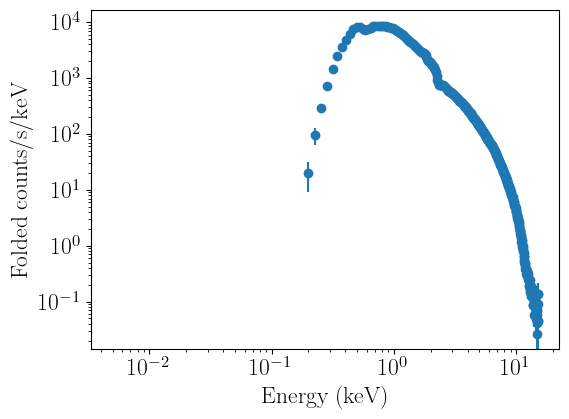

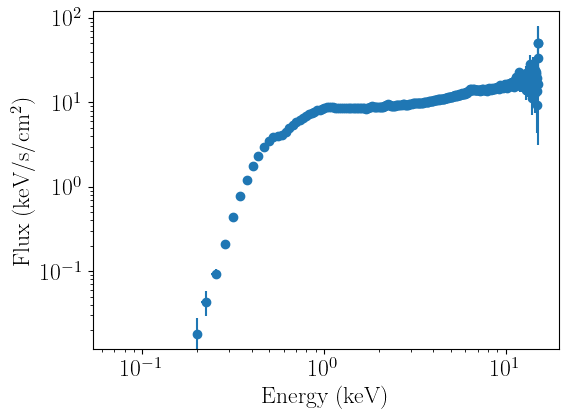

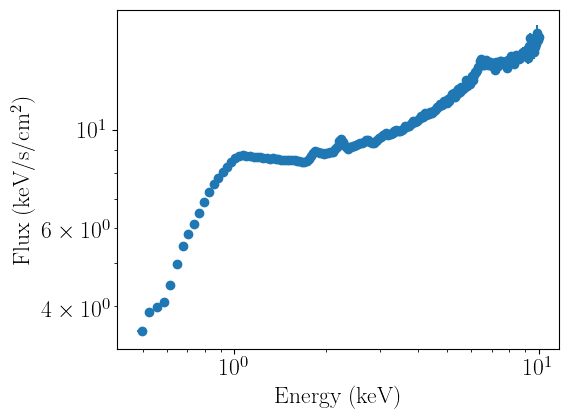

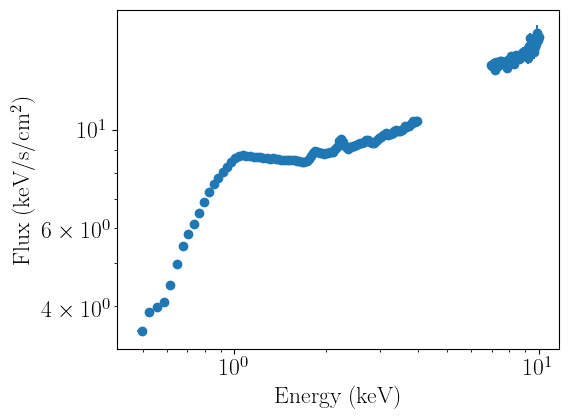

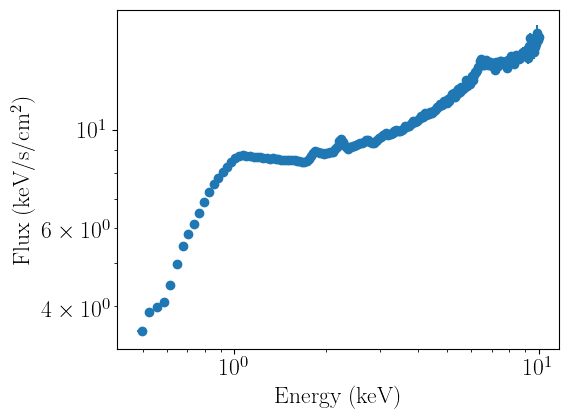

In [3]:
spectrum_fit.plot_data(units='data')
spectrum_fit.plot_data(units='eeunfold')
spectrum_fit.ignore_energies(0,0.5)
spectrum_fit.ignore_energies(10.0,20.0)
spectrum_fit.plot_data(units='eeunfold')
spectrum_fit.ignore_energies(4.0,7.0)
spectrum_fit.plot_data(units='eeunfold')
spectrum_fit.notice_energies(4.0,7.0)
spectrum_fit.plot_data(units='eeunfold')

## Defining a model and preparing a fit

We can now define a model to fit our data. In this case, we are analyzing the hard state of an X-ray binary, so we will use a phenomenological model with a disk component, a corona/power-law component, and correct both for line-of-sight absorption.

For the power-law component, we can wrap the corresponding function in the nDspec models library. Instead, for a disk model and line of sight absorption, we need to wrap calls to PyXspec. The latter calls are extremely computationally inefficient, but at the moment they are the only way of accessing the Xspec model library. A more optimized model interface will be available with future versions of nDspec.

In [4]:
from scipy.interpolate import interp1d
from xspec import *
Xset.chatter = 0 

def powerlaw(energ,index,norm_pl):
    par_array = np.array([norm_pl,index])
    model = models.powerlaw(energ,par_array)
    return model 

#dear god this is awful - also probably a messed up implementation
def wrap_diskbb(energ,kT,norm_disk):
    model = Model("diskbb")
    model.diskbb.Tin = kT
    model.diskbb.norm = norm_disk
    Plot("model")
    diskbb_x = np.array(Plot.x())
    diskbb_y = np.array(Plot.model())
    interp_obj = interp1d(diskbb_x,diskbb_y,fill_value='extrapolate')   
    model = interp_obj(energ)*energ
    return model

#and so is this
#can take this and e..g take the model output to a power of the nH I want - e.g. 
#set it to 10^21, return model, or for 10^22 return1 10^model
def wrap_tbabs(energ,nH):
    model = Model("tbabs*po")
    model.TBabs.nH = nH
    model.powerlaw.PhoIndex = 0.0
    model.powerlaw.norm = 1.0
    Plot("model")
    tbabs_x = np.array(Plot.x())
    tbabs_y = np.array(Plot.model())
    interp_obj = interp1d(tbabs_x,tbabs_y,fill_value='extrapolate')   
    model = interp_obj(energ) 
    return model

After defining the model functions, we can create an lmfit `Model` object using the standard synthax from other X-ray modelling softwares, ie absorption*(disk+powerlaw). We then initialize the parameter values using the `make_params` method of lmfit `Model` objects - here, `index` is the power-law photon index, `norm_pl` the power-law normalization, `kT` the diskbb temperature, `norm_disk` the diskbb normalization, and `nH` the absorbing column density. `make_params` returns an lmfit `Parameters` object, which can then be assigned to our fitter.

Once the model and its starting parameters are defined, we can assign them to our fitter object with the `set_model` method. Then, after the data, model, and initial parameters are loaded, we can use the `pretty_print` and `print_fit_stat` method to get an idea on the fit statistics for our current set of parameters.

In [5]:
from lmfit import Model as LM_Model

#define my unfolded model - this will be the only thing users have to define
unfolded_model = LM_Model(wrap_tbabs)*(LM_Model(powerlaw)+LM_Model(wrap_diskbb))

start_params = unfolded_model.make_params(index=dict(value=-1.65,min=-3.0,max=-1.0),
                                          norm_pl=dict(value=6.5,min=1e-1,max=50.),
                                          kT=dict(value=0.25,min=0.10,max=1),
                                          norm_disk=dict(value=2e5,min=1e1,max=1e8),
                                          nH=dict(value=0.1,min=1e-3,max=2))

spectrum_fit.set_model(unfolded_model,params=start_params)
spectrum_fit.model_params.pretty_print()
spectrum_fit.print_fit_stat()

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
index         -1.65       -3       -1     None     True     None     None
kT             0.25      0.1        1     None     True     None     None
nH              0.1    0.001        2     None     True     None     None
norm_disk     2e+05       10    1e+08     None     True     None     None
norm_pl         6.5      0.1       50     None     True     None     None
Goodness of fit metrics:
Chi squared             2308.0280044761303
Reduced chi squared     10.034904367287522
Data bins:              235
Free parameters:        5
Degrees of freedom:     230


Plotting the model and data together can be done with the `plot_model` method. Identically to `plot_data`, users can use both folded and model-independent unfolded units:

/home/matteo/Software/nDspec/src/ndspec/Response.py:644: RuntimeWarning: invalid value encountered in divide
  unfold_model = array/unfold_array*channel_widths
/home/matteo/Software/nDspec/src/ndspec/Response.py:644: RuntimeWarning: divide by zero encountered in divide
  unfold_model = array/unfold_array*channel_widths


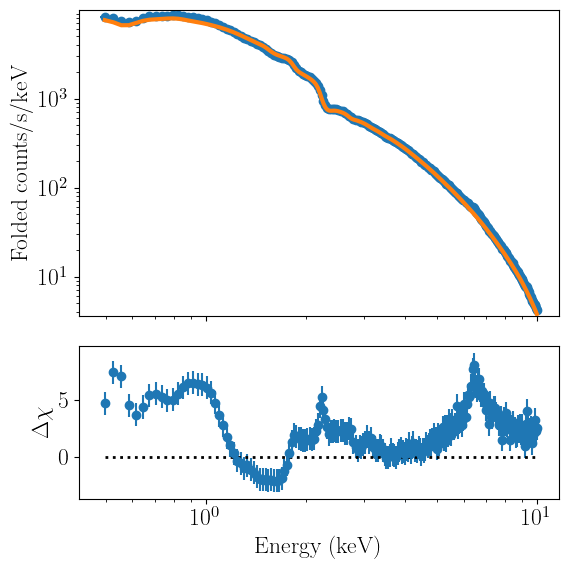

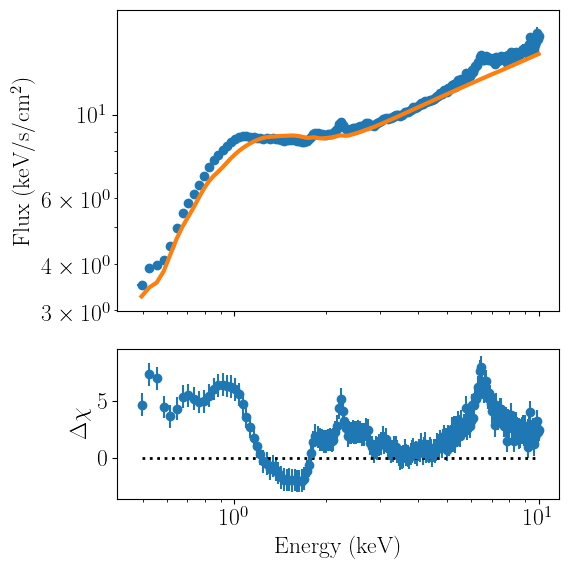

In [6]:
spectrum_fit.plot_model(units='data')
spectrum_fit.plot_model(units='eeunfold')

## Running a fit

We can now fit the data by minimizing the least-chi squares statistic with the `fit_data` method. Once the fit completes, the method will output the best-fit statistics and their corresponding parameter values:

In [7]:
spectrum_fit.fit_data()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 57
    # data points      = 235
    # variables        = 5
    chi-square         = 643.872328
    reduced chi-square = 2.79944490
    Akaike info crit   = 246.860012
    Bayesian info crit = 264.157939
[[Variables]]
    nH:         0.09136439 +/- 0.00472511 (5.17%) (init = 0.1)
    index:     -1.59763896 +/- 0.00704034 (0.44%) (init = -1.65)
    norm_pl:    6.25158218 +/- 0.07408392 (1.19%) (init = 6.5)
    kT:         0.23975053 +/- 0.00466251 (1.94%) (init = 0.25)
    norm_disk:  287698.701 +/- 38053.9294 (13.23%) (init = 200000)


It is extremely important to note that the error bars reported by these least-chi squares are often highly misleading, particularly for cases with relatively complex parameter spaces (as is the case for high signal/noise X-ray spectra). These intervals should only be used as a rough indication of how well parameters can be constrained. They should NOT be included in peer-reviewed research as credible parameter intervals. Instead, users are highly encouraged to use and report credible intervals from Bayesian sampling; the tutorial on [fitting power spectra](https://ndspec.readthedocs.io/en/latest/fit_psd.html) discusses how to do this in nDspec.

Once the fit is complete, we can plot the best-fitting model together with its components. Not that multiplicative components (such as tbabs) will not display correctly with the current implementation of nDspec. As a result, the automated plots from `plot_model` may not be good enough to be included in a scientific publication. This will be improved in a future version. Regardless, the relevant arrays (e.g. model values, data points, etc) are all accessible outside of the class. Users can find more information on the arrays required to create their own plots in the [nDspec API documentation page](https://ndspec.readthedocs.io/en/latest/api.html#ndspec.FitTimeAvgSpectrum.FitTimeAvgSpectrum).

/home/matteo/Software/nDspec/src/ndspec/Response.py:644: RuntimeWarning: invalid value encountered in divide
  unfold_model = array/unfold_array*channel_widths
/home/matteo/Software/nDspec/src/ndspec/Response.py:644: RuntimeWarning: divide by zero encountered in divide
  unfold_model = array/unfold_array*channel_widths
/home/matteo/Software/nDspec/src/ndspec/Response.py:644: RuntimeWarning: invalid value encountered in divide
  unfold_model = array/unfold_array*channel_widths
/home/matteo/Software/nDspec/src/ndspec/Response.py:644: RuntimeWarning: invalid value encountered in divide
  unfold_model = array/unfold_array*channel_widths
/home/matteo/Software/nDspec/src/ndspec/Response.py:644: RuntimeWarning: invalid value encountered in divide
  unfold_model = array/unfold_array*channel_widths


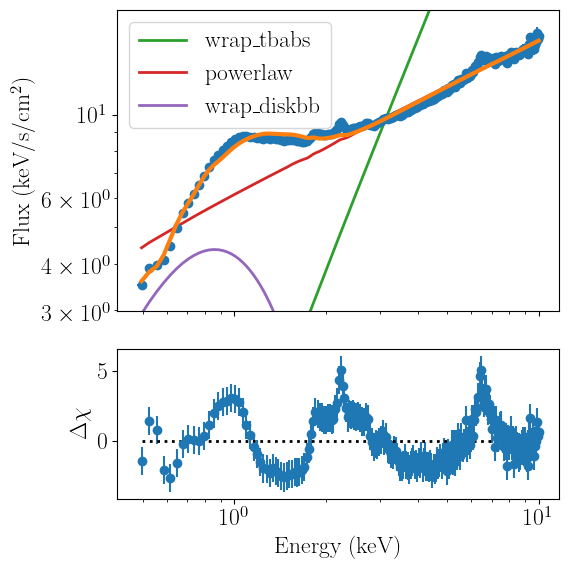

In [8]:
spectrum_fit.plot_model(units='eeunfold',plot_components=True)

Having run our fit and plotted our results, we can conclude that this spectrum shows the typical features of an accreting black hole in the hard state: the disk is relatively weak and only contributes below 1 keV, much of the total luminosity is emitted by the power-law component, and the residuals show clear reflection features.